In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

file_path = '/content/drive/MyDrive/Data Science Project - Sem 05 - Raleesa/Datasets/new_bin_dataset.csv'

df = pd.read_csv(file_path)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,observation_date,fedfunds,TB3MS,TB6MS,TB1YR,USTPU,USGOOD,SRVPRD,USCONS,MANEMP,...,PCEPI,PSAVERT,PSTAX,COMREAL,COMLOAN,SECURITYBANK,PPIACO,M1SL,M2SL,recession
0,1959-07-01,3.47,3.20,3.82,4.34,10977,19529,34275,3087,15623,...,15.303,10.7,42.679,23451.0,18.3,2.1,31.7,141.7,295.2,0
1,1959-08-01,3.50,3.38,3.87,4.31,11004,19049,34287,3085,15202,...,15.325,9.6,42.679,23451.0,12.0,-32.0,31.6,141.9,296.4,0
2,1959-09-01,3.76,4.04,4.70,4.83,10991,19052,34376,3051,15254,...,15.365,8.7,42.679,23451.0,5.9,-8.8,31.7,141.0,296.7,0
3,1959-10-01,3.98,4.05,4.53,4.69,10994,18925,34433,3016,15158,...,15.402,9.4,43.733,23463.0,3.0,-13.3,31.6,140.5,296.5,0
4,1959-11-01,4.00,4.15,4.54,4.54,11014,19108,34526,3025,15300,...,15.412,10.1,43.733,23463.0,8.8,-7.8,31.5,140.4,297.1,0


In [4]:
df.columns

Index(['observation_date', 'fedfunds', 'TB3MS', 'TB6MS', 'TB1YR', 'USTPU',
       'USGOOD', 'SRVPRD', 'USCONS', 'MANEMP', 'USWTRADE', 'USTRADE', 'USINFO',
       'UNRATE', 'UNEMPLOY', 'CPIFOOD', 'CPIMEDICARE', 'CPIRENT', 'CPIAPP',
       'GDP', 'REALGDP', 'PCEPI', 'PSAVERT', 'PSTAX', 'COMREAL', 'COMLOAN',
       'SECURITYBANK', 'PPIACO', 'M1SL', 'M2SL', 'recession'],
      dtype='object')

In [6]:
#target variables
df['recession_1m'] = df['recession'].shift(-1)   # 1 month ahead
df['recession_3m'] = df['recession'].shift(-3)   # 3 months ahead
df['recession_6m'] = df['recession'].shift(-6)   # 6 months ahead

In [7]:
df = df.dropna()

pd.set_option('display.max_rows', None)
print(df.isnull().sum())
pd.reset_option('display.max_rows')

observation_date    0
fedfunds            0
TB3MS               0
TB6MS               0
TB1YR               0
USTPU               0
USGOOD              0
SRVPRD              0
USCONS              0
MANEMP              0
USWTRADE            0
USTRADE             0
USINFO              0
UNRATE              0
UNEMPLOY            0
CPIFOOD             0
CPIMEDICARE         0
CPIRENT             0
CPIAPP              0
GDP                 0
REALGDP             0
PCEPI               0
PSAVERT             0
PSTAX               0
COMREAL             0
COMLOAN             0
SECURITYBANK        0
PPIACO              0
M1SL                0
M2SL                0
recession           0
recession_1m        0
recession_3m        0
recession_6m        0
dtype: int64


In [8]:
import wandb
wandb.login(key="26eaf8aee8b1652724751320dee2235031382a44")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: raleesa-22 (raleesa-22-university-of-moratuwa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [9]:
import wandb
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, precision_recall_curve,
    classification_report
)
from tensorflow.keras.callbacks import Callback
import random, os
from tensorflow.keras import regularizers
from tensorflow.keras.layers import TimeDistributed
import tensorflow.keras.backend as K

# ----------------------------
# Config / W&B init
# ----------------------------
wandb.init(
    project="us-recession-transformer-lstm-hybrid",
    config={
        "seq_length": 12,
        "lstm_units": 64, #64 -> 32
        "d_model":32, #32 -> 16
        "num_heads": 2,
        "ff_dim": 64, #64
        "num_layers": 1,
        "dropout": 0.1, #0.18
        "batch_size": 16, #16
        "learning_rate": 5e-4, #5e-4
        "epochs": 200, #200
        "focal_gamma": 2.0,
        "focal_alpha": 0.9,
        "use_class_weight": True,
        "class_weight_pos": 12,   #12.0
    }
)
config = wandb.config

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# ----------------------------
# Focal loss (binary)
# ----------------------------
def focal_loss(gamma=2., alpha=0.9):
    def loss(y_true, y_pred):
        # clip to prevent log(0) issues
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        bce = - (y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        mod_factor = (1 - p_t) ** gamma
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return K.mean(alpha_factor * mod_factor * bce)
    return loss

# ----------------------------
# Transformer building blocks
# ----------------------------
class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        key_dim = max(1, d_model // num_heads)
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = models.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(d_model),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(layers.Layer):
    def call(self, x, training=None):
        seq_len = tf.shape(x)[1]
        d_model = tf.shape(x)[2]
        pos = tf.cast(tf.range(seq_len)[:, tf.newaxis], tf.float32)
        i = tf.cast(tf.range(d_model)[tf.newaxis, :], tf.float32)
        angle_rates = 1 / tf.pow(10000.0, (2 * (i//2)) / tf.cast(d_model, tf.float32))
        angle_rads = pos * angle_rates
        sines = tf.sin(angle_rads[:, 0::2])
        cosines = tf.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        pos_encoding = tf.cast(pos_encoding, x.dtype)
        return x + pos_encoding


# ----------------------------
# compute val PR-AUC each epoch and optionally stop on no improvement
# ----------------------------
class ValPRCallback(Callback):
    def __init__(self, validation_data, patience=15, minimize=False, verbose=1):
        super().__init__()
        self.X_val, self.y_val = validation_data
        self.best = -np.inf
        self.patience = patience
        self.wait = 0
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs=None):
        y_val_prob = self.model.predict(self.X_val, verbose=0).flatten()
        pr_auc = average_precision_score(self.y_val, y_val_prob)
        logs = logs or {}
        logs['val_pr_auc'] = pr_auc
        wandb.log({"val_pr_auc": pr_auc})
        if self.verbose:
            print(f" — val_pr_auc: {pr_auc:.4f}")

        # early stopping logic on PR-AUC (maximize)
        if pr_auc > self.best + 1e-6:
            self.best = pr_auc
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"Stopping training: no improvement in val_pr_auc for {self.patience} epochs (best={self.best:.4f})")
                self.model.stop_training = True

# ----------------------------
# 3. Prepare dataset
# ----------------------------
target_col = "recession_1m"
df = df.copy()
df['observation_date'] = pd.to_datetime(df['observation_date'])

cols_to_drop = ['observation_date', 'recession', 'recession_1m', 'recession_3m', 'recession_6m']
cols_to_drop = [c for c in cols_to_drop if c in df.columns]
feature_cols = [c for c in df.columns if c not in cols_to_drop + [target_col]]

X = df[feature_cols].values
y = df[target_col].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ----------------------------
# 4. Sequence creation
# ----------------------------
def create_sequences(X, y, dates, seq_length):
    X_seq, y_seq, d_seq = [], [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
        d_seq.append(dates[i])
    return np.array(X_seq), np.array(y_seq), np.array(d_seq)

X_seq, y_seq, d_seq = create_sequences(
    X_scaled, y, df['observation_date'].values, config.seq_length
)

# ----------------------------
# 5. Date-based split
# ----------------------------
train_end_date = "1994-01-01"
val_end_date   = "2004-01-01"

# train_end_date = "1995-01-01"
# val_end_date   = "2008-06-01"

train_mask = d_seq <= np.datetime64(train_end_date)
val_mask   = (d_seq > np.datetime64(train_end_date)) & (d_seq <= np.datetime64(val_end_date))
test_mask  = d_seq > np.datetime64(val_end_date)

X_train, y_train = X_seq[train_mask], y_seq[train_mask]
X_val, y_val     = X_seq[val_mask], y_seq[val_mask]
X_test, y_test   = X_seq[test_mask], y_seq[test_mask]

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")


# ----------------------------
# Build the hybrid model: LSTM -> Transformer
# ----------------------------
# Input shape: (seq_len, n_features)
n_features = X_train.shape[2]
seq_len = X_train.shape[1]

inputs = layers.Input(shape=(seq_len, n_features))

# optional small projection to help LSTM (you can remove if not needed)
x = layers.Dense(config.d_model, activation=None)(inputs)

# # LSTM encoder (return sequences) -------------------------------------------------------------
x = layers.LSTM(config.lstm_units, return_sequences=True)(x)

x = layers.Dropout(config.dropout)(x)
#x = layers.SpatialDropout1D(config.dropout)(x)
#x = layers.LayerNormalization(epsilon=1e-6)(x) #-----------------------------------------------

# project LSTM outputs to d_model for transformer residual consistency ----------------------------
x = layers.Dense(config.d_model)(x)

# add positional encoding and transformer blocks
x = PositionalEncoding()(x)
# x = PositionalEncoding(seq_len, config.d_model)(x)

for _ in range(config.num_layers):
    x = TransformerBlock(config.d_model, config.num_heads, config.ff_dim, config.dropout)(x)

# Pooling + classifier
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(config.dropout)(x)
x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=config.learning_rate),
    loss=focal_loss(gamma=config.focal_gamma, alpha=config.focal_alpha),
    #loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ----------------------------
# Fit: callbacks & class weights
# ----------------------------
val_pr_cb = ValPRCallback(validation_data=(X_val, y_val), patience=20)

if config.use_class_weight:
    class_weight = {0: 1.0, 1: float(config.class_weight_pos)}
else:
    class_weight = None

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=config.epochs,
    batch_size=config.batch_size,
    shuffle=False,
    callbacks=[val_pr_cb]
    #callbacks=[val_pr_cb, wandb.keras.WandbCallback(save_graph=False, save_model=False)]
    ,
    class_weight=class_weight
)


# ----------------------------
# Threshold selection (validation only)
# ----------------------------
chosen_thresh = 0.71 #0.71
# chosen_thresh = best_f1_thresh
#chosen_thresh = best_j_thresh


# ----------------------------
# Evaluate on test
# ----------------------------
y_test_prob = model.predict(X_test).flatten()
y_pred = (y_test_prob >= chosen_thresh).astype(int)

acc = accuracy_score(y_test, y_pred)
prec_score_val = precision_score(y_test, y_pred, zero_division=0)
rec_score = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_test_prob)
pr_auc = average_precision_score(y_test, y_test_prob)

print("\nHybrid LSTM + Transformer Model Results - 1m recession")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec_score_val:.4f}")
print(f"Recall     : {rec_score:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"ROC-AUC    : {roc_auc:.4f}")
print(f"PR-AUC     : {pr_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Log final numbers to W&B
# wandb.summary["chosen_threshold"] = float(chosen_thresh)
# wandb.summary["best_f1_threshold"] = float(best_f1_thresh)
# wandb.summary["recall_first_threshold"] = float(recall_first_thresh)
wandb.summary["test_accuracy"] = acc
wandb.summary["f1_score"] = f1
wandb.summary["precision"] = prec_score_val
wandb.summary["recall"] = rec_score
wandb.summary["roc_auc"] = roc_auc
wandb.summary["pr_auc"] = pr_auc


Train size: 403, Val size: 120, Test size: 253


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 29)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12, 32)         │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 12, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, 12, 32)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 12, 32)         │         8,544 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,505 (146.50 KB)

 Trainable params: 37,505 (146.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1627 - loss: 0.1594 — val_pr_auc: 0.0711
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.1626 - loss: 0.1592 - val_accuracy: 0.0667 - val_loss: 0.0378 - val_pr_auc: 0.0711
Epoch 2/200
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1682 - loss: 0.1273 — val_pr_auc: 0.0844
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1690 - loss: 0.1272 - val_accuracy: 0.2750 - val_loss: 0.0304 - val_pr_auc: 0.0844
Epoch 3/200
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2465 - loss: 0.1015 — val_pr_auc: 0.3510
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2473 - loss: 0.1016 - val_accuracy: 0.3750 - val_loss: 0.0235 - val_pr_auc: 0.3510
Epoch 4/200
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5641 - loss: 0.1288 — val_pr_auc: 0.3402
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5471 - loss: 0.1267 - val_accuracy: 0.3417 - val_loss: 0.0264 - val_pr_auc: 0.3402
Epoch 5/200
26/26 ━━━━━━

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


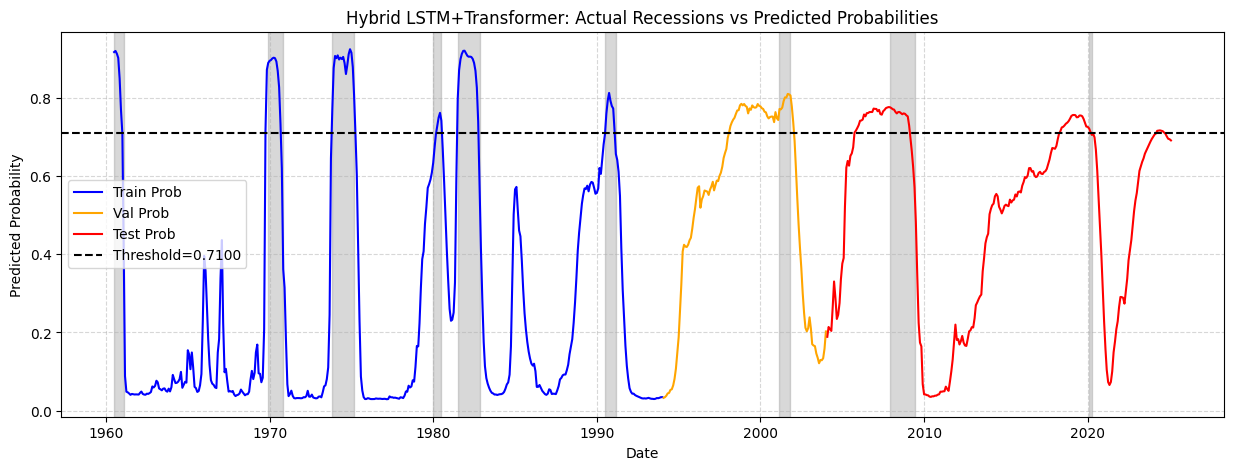

In [10]:
import matplotlib.pyplot as plt

# ----------------------------
# 1. Convert split dates to pandas datetime
# ----------------------------
train_dates = pd.to_datetime(d_seq[train_mask])
val_dates   = pd.to_datetime(d_seq[val_mask])
test_dates  = pd.to_datetime(d_seq[test_mask])

# ----------------------------
# 2. Predictions for each split
# ----------------------------
# Train
preds_prob_train = pd.Series(model.predict(X_train).flatten(), index=train_dates)
preds_class_train = (preds_prob_train >= chosen_thresh).astype(int)
actuals_train = pd.Series(y_train, index=train_dates)

# Validation
preds_prob_val = pd.Series(model.predict(X_val).flatten(), index=val_dates)
preds_class_val = (preds_prob_val >= chosen_thresh).astype(int)
actuals_val = pd.Series(y_val, index=val_dates)

# Test
preds_prob_test = pd.Series(y_test_prob, index=test_dates)   # from evaluation step
preds_class_test = pd.Series(y_pred, index=test_dates)       # already thresholded
actuals_test = pd.Series(y_test, index=test_dates)

# ----------------------------
# 3. Combined probability plot
# ----------------------------
plt.figure(figsize=(15, 5))

# Shade recession periods (based on actual labels across all splits)
all_actuals = pd.concat([actuals_train, actuals_val, actuals_test])
in_recession = False
start_date = None
for date, value in all_actuals.items():
    if value == 1 and not in_recession:
        start_date = date
        in_recession = True
    elif value == 0 and in_recession:
        plt.axvspan(start_date, date, color='gray', alpha=0.3)
        in_recession = False
if in_recession:
    plt.axvspan(start_date, all_actuals.index[-1], color='gray', alpha=0.3)

# Plot predicted probabilities
plt.plot(preds_prob_train.index, preds_prob_train, color='blue', label='Train Prob')
plt.plot(preds_prob_val.index, preds_prob_val, color='orange', label='Val Prob')
plt.plot(preds_prob_test.index, preds_prob_test, color='red', label='Test Prob')

# Add threshold line
plt.axhline(y=chosen_thresh, color='black', linestyle='--', label=f'Threshold={chosen_thresh:.4f}')

plt.title("Hybrid LSTM+Transformer: Actual Recessions vs Predicted Probabilities")
plt.xlabel("Date")
plt.ylabel("Predicted Probability")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# ----------------------------
# 4. Example: validation table
# ----------------------------
table_val = pd.DataFrame({
    "Date": actuals_val.index,
    "Actual": actuals_val.values,
    "Predicted": preds_class_val.values,
    "Pred_Prob": preds_prob_val.values
})

#display(table_val.head(20))


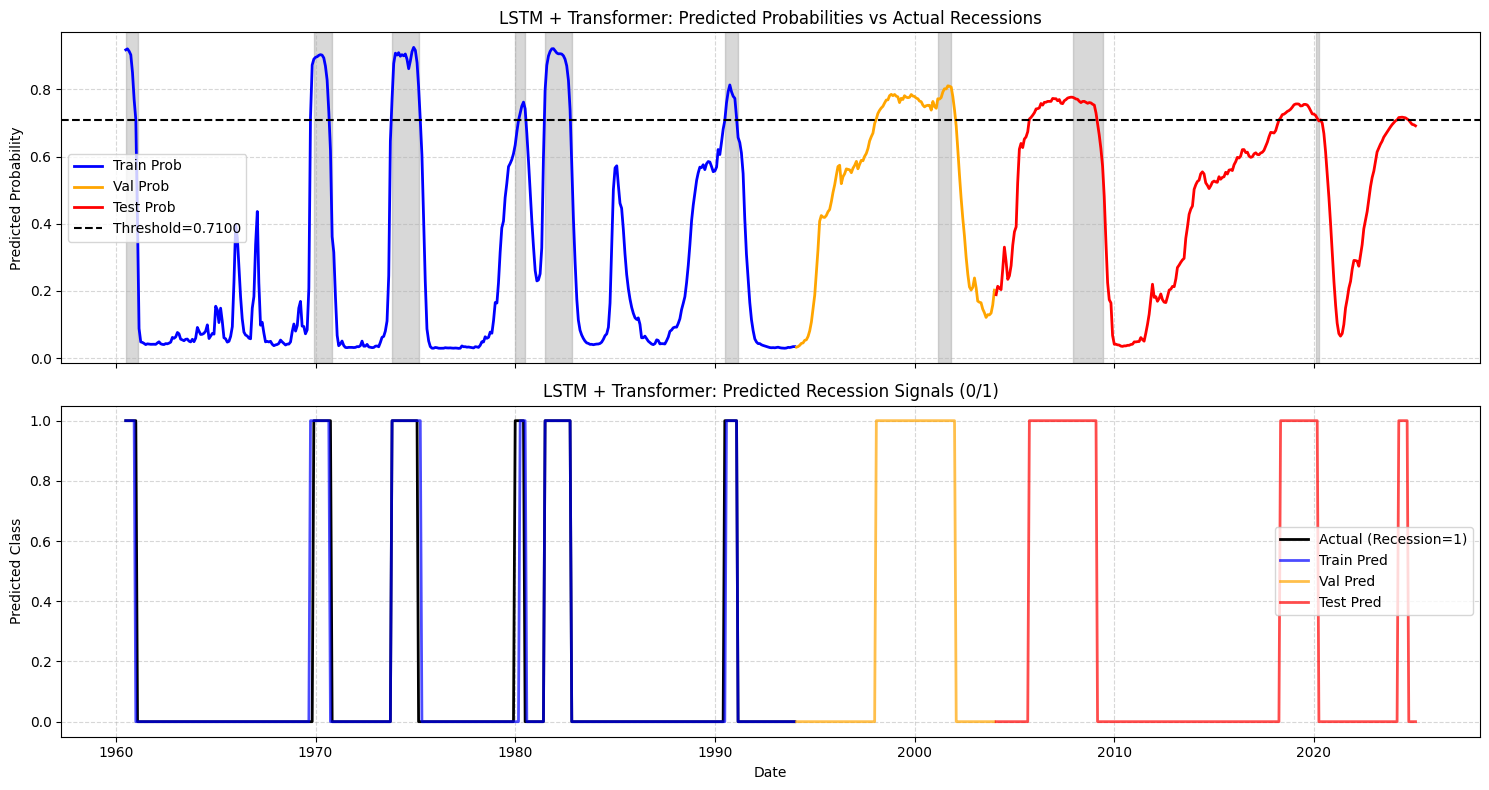

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# ----------------------------
# Subplot 1: Predicted Probabilities
# ----------------------------
axes[0].plot(preds_prob_train.index, preds_prob_train, color='blue', label='Train Prob', linewidth=2)
axes[0].plot(preds_prob_val.index, preds_prob_val, color='orange', label='Val Prob', linewidth=2)
axes[0].plot(preds_prob_test.index, preds_prob_test, color='red', label='Test Prob', linewidth=2)

# Shade recession periods from actual labels
all_actuals = pd.concat([actuals_train, actuals_val, actuals_test])
in_recession = False
start_date = None
for date, value in all_actuals.items():
    if value == 1 and not in_recession:
        start_date = date
        in_recession = True
    elif value == 0 and in_recession:
        axes[0].axvspan(start_date, date, color='gray', alpha=0.3)
        in_recession = False
if in_recession:
    axes[0].axvspan(start_date, all_actuals.index[-1], color='gray', alpha=0.3)

# Add threshold line
axes[0].axhline(y=chosen_thresh, color='black', linestyle='--', linewidth=1.5,
                label=f'Threshold={chosen_thresh:.4f}')

axes[0].set_title("LSTM + Transformer: Predicted Probabilities vs Actual Recessions")
axes[0].set_ylabel("Predicted Probability")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.5)

# ----------------------------
# Subplot 2: Predicted Classes
# ----------------------------
axes[1].plot(actuals_train.index, actuals_train, color='black',
             label='Actual (Recession=1)', linewidth=2)
axes[1].plot(preds_class_train.index, preds_class_train, color='blue',
             alpha=0.7, label='Train Pred', linewidth=2)
axes[1].plot(preds_class_val.index, preds_class_val, color='orange',
             alpha=0.7, label='Val Pred', linewidth=2)
axes[1].plot(preds_class_test.index, preds_class_test, color='red',
             alpha=0.7, label='Test Pred', linewidth=2)

axes[1].set_title("LSTM + Transformer: Predicted Recession Signals (0/1)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Predicted Class")
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
